# Read and feed data to CNTK Trainer

Feeding data is an integral part of training a deep neural network.  While expressiveness and succinct model representation is one of the key aspects of CNTK, efficient and flexible data reading is also made available to the users.  Key to deep learning is the ability to provide randomly sampled training data to the CNTK model trainers. These small sampled data sets are called mini-batches. In this manual, we show how minibatch samples can be read from data sources and passed on to trainer objects. The built-in readers follow [convention over configuration principle](https://en.wikipedia.org/wiki/Convention_over_configuration) and greatly simplify training procedure.

One of the following four mechanisms to read data should cover the different use cases when it comes to training a model: 

A. **Small data (in memory)** or **Chunked Data in Numpy/SciPy**: Users can generate own data using *NumPy* or read in data as *NumPy* arrays or *SciPy* sparse (CSR) matrices. This is the way to go when data set is small and can be loaded in memory. This option is a good choice if one does pre-processing of data and have data in a format that fits into *NumPy* arrays or *SciPy* sparse matrices. In such cases one would read data in small chuncks, pre-process and feed to *Numpy*/*SciPy* data containers.

B. **Large data (cannot be loaded in memory)**: 

> (1) Using built-in **MinibatchSource** class is the choice when data cannot be loaded in memory and one wants to build models leveraging distributed computing capabilities in CNTK. This is supported via built-in readers and optional parameters that help reduce writing what otherwise would be considered as boiler plate code. 

> (2) Using explicit **minibatch-loop** when data being used does not fit in one of the aforementioned categories. For instance, if one needs to alter training parameters based on certain loss conditions, an explicit control over the training loop is desirable. 

C. **Custom data**: In case the built-in readers are not adequate and one is using CNTK's training session constructs (that will be explained in the tutorial) or needs data to be formatted for distributed scenarios, creating a custom minibatch source is a suggested option. 

We will use a text data reader to walk you through the aforementioned options. CNTK does support image and speech data as well. We will discuss how to read those data types towards the end.

In [1]:
from __future__ import print_function
import cntk as C
import numpy as np
import os
import requests
import scipy.sparse

import cntk.tests.test_utils
cntk.tests.test_utils.set_device_from_pytest_env() # (only needed for CNTK internal build system)

The sections A - C below are applicable to any model architecture when using CNTK. For illustration of how the different data feeding options can be leveraged with a CNTK model for training, we will use a simple Logistic Regression model in this notebook. 


## A. Small data (in memory)

The `train()` and `test()` functions accept a tuple of NumPy arrays or SciPy sparse matrices (in CSR format) for their `minibatch_source` arguments.
The tuple members must be in the same order as the arguments of the `criterion` function that `train()` or `test()` are called on.
For dense tensors, use NumPy arrays, while sparse data should have the type `scipy.sparse.csr_matrix`.

Each of the arguments should be a Python list of NumPy/SciPy arrays, where each list entry represents a data item. For arguments declared as a sequence, the first axis (dimension) of the NumPy/SciPy array is the sequence length, while the remaining axes are the shape of each element of the sequence. Arguments that are not sequences consist of a single tensor. The shapes, data types (`np.float32/float64`) and sparseness must match the argument types.  

As an optimization, arguments that are not sequences can also be passed as a single large numpy/scipy array (instead of a list).

**Note**: 
- It is the responsibility of the user to randomize the data.
- It is the responsibility of the user to provide the data in a row major memory layout that CNTK uses for the python interface. In C++ interface we use a columun major format.. This becomes more relevant for Tensors of higher dimensions. Refer to the Image data section later in the notebook for more information.

In [2]:
# Generate your own data
input_dim_lr = 2    # classify 2-dimensional data
num_classes_lr = 2  # into one of two classes

# This example uses synthetic data from normal distributions,
# which we generate in the following.
#  X_lr[corpus_size,input_dim] - input data
#  Y_lr[corpus_size]           - labels (0 or 1), one-hot-encoded
np.random.seed(0)
def generate_synthetic_data(N):
    Y = np.random.randint(size=N, low=0, high=num_classes_lr)  # labels
    X = (np.random.randn(N, input_dim_lr)+3) * (Y[:,None]+1)   # data
    # Our model expects float32 features, and cross-entropy
    # expects one-hot encoded labels.
    Y = scipy.sparse.csr_matrix((np.ones(N,np.float32), (range(N), Y)), shape=(N, num_classes_lr))
    X = X.astype(np.float32)
    return X, Y
X_train_lr, Y_train_lr = generate_synthetic_data(20000)
X_test_lr,  Y_test_lr  = generate_synthetic_data(1024)
print('data =\n', X_train_lr[:4])
print('labels =\n', Y_train_lr[:4].todense())

data =
 [[ 2.2741797   3.56347561]
 [ 5.12873602  5.79089499]
 [ 1.3574543   5.5718112 ]
 [ 3.54340553  2.46254587]]
labels =
 [[ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]]


We create a small model and train on the data. Note: this manual does not focus on training instead just on different ways to pass data into the trainers.

In [3]:
## Define a small Logistic Regression model function
x = C.input_variable(input_dim_lr)
y = C.input_variable(num_classes_lr, is_sparse=True)
model = C.layers.Dense(num_classes_lr, activation=None)
loss = C.cross_entropy_with_softmax(model(x), y) # applies softmax to the model output under the hood
print(loss)

Composite(Tensor[2], SparseTensor[2]) -> Tensor[1]


### Feed NumPy data from memory

In [4]:
learner = C.sgd(model.parameters,
                C.learning_rate_schedule(0.1, C.UnitType.minibatch))
progress_writer = C.logging.ProgressPrinter(0)

train_summary = loss.train((X_train_lr, Y_train_lr), parameter_learners=[learner],
                   callbacks=[progress_writer])

 average      since    average      since      examples
    loss       last     metric       last              
 ------------------------------------------------------
Learning rate per minibatch: 0.1
     3.58       3.58          0          0            32
     1.61      0.629          0          0            96
      1.1      0.715          0          0           224
     0.88      0.688          0          0           480
    0.734      0.598          0          0           992
    0.637      0.543          0          0          2016
    0.541      0.447          0          0          4064
     0.45      0.359          0          0          8160
    0.366      0.284          0          0         16352


Note: We have not set any function defining the `metric`. Hence, you see the metric values are all set to 0.0. The plot below shows how the loss reduces with the training iterations. 

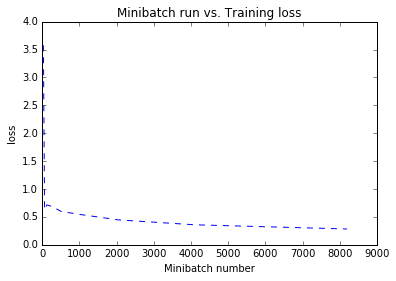

In [5]:
from collections import defaultdict

plotdata = defaultdict(list)
for d in train_summary['updates']:
    plotdata["samples"].append(d["samples"])
    plotdata["loss"].append(d["loss"])

# Plot the data 
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(plotdata["samples"], plotdata["loss"], 'b--')
plt.xlabel("Minibatch number")
plt.ylabel("loss")
plt.title('Minibatch run vs. Training loss')
plt.show()

### Feed NumPy data for sequences

Many real world data involving a notion of time (such as stock market data) or notion of state (such as words in a sentence or utterances in a speech recording) present data in the form of sequences. Sequences are often modelled using recurrent networks (RNNs). CNTK makes it really easy to model such networks and requires one to specify their input variables as `C.sequence.input` instead of `C.input_variables`. [Introduction to sequence modeling](https://cntk.ai/pythondocs/sequence.html#sequence-classification) and [feeding sequences with NumPy](https://cntk.ai/pythondocs/sequence.html#feeding-sequences-with-numpy) provide details on how to model sequence data in CNTK. 

## B. Large data (not in memory)

In deep learning modeling the data often may not fit into memory (RAM). For this case, CNTK provides the `MinibatchSource` class

### B.1 Feeding data using the `MinibatchSource` class 

`MinibatchSource` class provides:

 * A **chunked randomization algorithm** that holds only part of the data in RAM at any given time.
 * **Distributed reading** where each worker reads a different subset.
 * A **transformation pipeline** for images and image augmentation.
 * **Composability** across multiple data types (e.g. image captioning).
 * Transparent **asynchronous loading** so that the GPU is not stalling while a minibatch is read/prepared 

At present, the `MinibatchSource` class implements a limited set of data types in the form of "deserializers":

 * **Text/Basic**: `CTFDeserializer`
 * **Image**: `ImageDeserializer`.
 * **Speech**: `HTKFeatureDeserializer`, `HTKMLFDeserializer`. 

We will discuss briefly about **Image** and **Speech** deserializers towards the end of this notebook. However, in this section we focus on utilizing the `MinibatchScource` using **CNTK text format (CTF)**, which consists of a set of named feature channels each containing a one dimensional sparse or dense sequence per example. The CTFDeserializer then associates as each feature channel with an input of your model or criterion. Another converter of great value is [Text to CTF converter](https://github.com/Microsoft/CNTK/blob/master/Scripts/txt2ctf.py).

Here we will read MNIST data using CTF deserializers. In addition to the [CTF format API](https://www.cntk.ai/pythondocs/_modules/cntk/io.html#CTFDeserializer) documentation, the format with respect to MNIST data and the deserialization features are illustrated in [CNTK 103B tutorial](https://github.com/Microsoft/CNTK/blob/master/Tutorials/CNTK_103B_MNIST_LogisticRegression.ipynb). We reuse the code from this tutorial to demonstrate the use of CTF file readers.

#### MNIST data reading using CTF deserializer

In this notebook we use the MNIST data downloaded using CNTK_103A_MNIST_DataLoader notebook. The dataset has 60,000 training images and 10,000 test images with each image being 28 x 28 pixels. Thus, the number of features is equal to 784 (= 28 x 28 pixels), 1 per pixel. The variable `num_output_classes` is set to 10 corresponding to the number of digits (0-9) in the dataset.

The data is in the following format:

    |labels 0 0 0 1 0 0 0 0 0 0 |features 0 0 0 0 ... 
                                                  (784 integers each representing a pixel)
    
In this tutorial we are going to use the image pixels corresponding the integer stream named "features". We define a `create_reader` function to read the training and test data using the [CTF deserializer](https://cntk.ai/pythondocs/cntk.io.html?highlight=ctfdeserializer#cntk.io.CTFDeserializer). The labels are [1-hot encoded](https://en.wikipedia.org/wiki/One-hot). Refer to CNTK 103A tutorial for a visual description of the one-hot representation.

Note: One can directly convert the input `features` stream (784 dimensional vector) from CTF reader to another input of say (1, 28, 28) shaped image (refer to [CNTK 103D tutorial](https://github.com/Microsoft/CNTK/blob/master/Tutorials/CNTK_103D_MNIST_ConvolutionalNeuralNetwork.ipynb)) for usage.

In [6]:
# Ensure the training and test data is generated and available for this tutorial.
# We search in two locations in the toolkit for the cached MNIST data set.
data_found = False

for data_dir in [os.path.join("..", "Examples", "Image", "DataSets", "MNIST"),
                 os.path.join("data", "MNIST")]:
    train_file = os.path.join(data_dir, "Train-28x28_cntk_text.txt")
    test_file = os.path.join(data_dir, "Test-28x28_cntk_text.txt")
    if os.path.isfile(train_file) and os.path.isfile(test_file):
        data_found = True
        break
        
if not data_found:
    raise ValueError("Please generate the data by completing CNTK 103 Part A")
    
print("Data directory is {0}".format(data_dir))

Data directory is ..\Examples\Image\DataSets\MNIST


In [7]:
# Define the data dimensions
mnist_input_dim = 784
mnist_num_output_classes = 10

# Read a CTF formatted text (as mentioned above) using the CTF deserializer from a file
def create_reader(path, is_training, input_dim, num_label_classes):
    
    labelStream = C.io.StreamDef(field='labels', shape=num_label_classes, is_sparse=False)
    featureStream = C.io.StreamDef(field='features', shape=input_dim, is_sparse=False)
    
    deserailizer = C.io.CTFDeserializer(path, C.io.StreamDefs(labels = labelStream, features = featureStream))
            
    return C.io.MinibatchSource(deserailizer,
       randomize = is_training, max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1)

Note, the class `cntk.io.MinibatchSource` uses CTFDeserializer, enables randomization and specifies number of sweeps to be made through the data. In deep learning, we take small randomly sampled instances of data and update the parameters of the model in an iterative manner. Making multiple passes through the data often improves the performance of a model as it learns to cope up with different instances of randomly sampled data. This makes specification of the number of sweeps important. In this case, since the data set is relatively small we set the value to `cntk.io.INFINITELY_REPEAT`. In case, you are faced with very large data sets and CPU memory pressure is high, reducing the size of the randomization window in chunks (`randomization_window_in_chunks`) can help in dealing with  memory resource utilization. 

In [8]:
# Create a MNIST LR model
## Define a small model function

x = C.input_variable(mnist_input_dim)
y = C.input_variable(mnist_num_output_classes)
model = C.layers.Dense(mnist_num_output_classes, activation=None)
z = model(x/255.0) #scale the input to 0-1 range
loss = C.cross_entropy_with_softmax(z, y)
learner = C.sgd(z.parameters,
                C.learning_rate_schedule(0.05, C.UnitType.minibatch))

#### Feeding data into `training_session`

Training session wraps a bunch of functionalities such as a minibatch source, a trainer and optionally a validation mini-batch source (Note: the . Additionally, it makes consistent checkpointing and reporting of training progress with a specified frequency. In the code below, we use the `training_session` class to accept data from the reader (using `cntk.io.Minibatchsource`). 

Note: The current mechanism for validation is mistakenly documented as cross-validation. With practical deep learning application, performing a k-fold cross validation can be expensive and time consuming. 

In [9]:
reader_train = create_reader(train_file, True, mnist_input_dim, mnist_num_output_classes)
minibatch_size = 64
input_map = {x : reader_train.streams.features, y : reader_train.streams.labels }
num_samples_per_sweep = 60000
num_sweeps_to_train_with = 10


progress_writer = C.logging.ProgressPrinter(0)
trainer = C.Trainer(z, (loss, None), learner, progress_writer)

C.train.training_session(
        trainer=trainer,
        mb_source = reader_train,
        mb_size = minibatch_size,
        model_inputs_to_streams = input_map,
        max_samples = num_samples_per_sweep * num_sweeps_to_train_with,
    ).train()

 average      since    average      since      examples
    loss       last     metric       last              
 ------------------------------------------------------
Learning rate per minibatch: 0.05
     2.33       2.33          0          0            64
     2.31        2.3          0          0           192
     2.22       2.16          0          0           448
     2.05        1.9          0          0           960
     1.81       1.58          0          0          1984
     1.48       1.16          0          0          4032
     1.16      0.842          0          0          8128
    0.898      0.639          0          0         16320
    0.701      0.504          0          0         32704
    0.561      0.422          0          0         65472
    0.465      0.369          0          0        131008
    0.398       0.33          0          0        262080
     0.35      0.303          0          0        524224


### B.2 Feeding data with full-control over each minibatch update 

This is the most granular method for feeding data into trainer. Note the `cntk.Trainer` class provides access to functions such as `previous_minibatch_loss_average` and `previous_minibatch_evaluation_average` to gain fine grain control over how the training proceeds.

In [10]:
z1 = model(x/255.0) #scale the input to 0-1 range
loss = C.cross_entropy_with_softmax(z1, y)
learner = C.sgd(z1.parameters,
                C.learning_rate_schedule(0.05, C.UnitType.minibatch))

num_minibatches_to_train = (num_samples_per_sweep * num_sweeps_to_train_with) / minibatch_size

progress_writer = C.logging.ProgressPrinter(0)
trainer = C.Trainer(z1, (loss, None), learner, progress_writer)

for i in range(0, int(num_minibatches_to_train)):
    
    # Read a mini batch from the training data file
    data = reader_train.next_minibatch(minibatch_size, input_map = input_map)
    
    trainer.train_minibatch(data)

 average      since    average      since      examples
    loss       last     metric       last              
 ------------------------------------------------------
Learning rate per minibatch: 0.05
    0.175      0.175          0          0            64
    0.342      0.426          0          0           192
    0.345      0.347          0          0           448
    0.311      0.282          0          0           960
    0.292      0.273          0          0          1984
    0.282      0.274          0          0          4032
    0.288      0.294          0          0          8128
    0.292      0.296          0          0         16320
    0.291       0.29          0          0         32704
    0.287      0.283          0          0         65472
    0.286      0.285          0          0        131008
    0.284      0.282          0          0        262080
     0.28      0.277          0          0        524224


## C. Custom data

When built-in readers are not adequate and one is using CNTK's training session constructs (with MinibatchSource class) for scenarios such as distributed training, creating a custom minibatch source is a suggested option. The extension can be written in pure Python.

We summarize the two steps for creating a [user defined minibatch source](https://cntk.ai/pythondocs/extend.html#user-defined-minibatch-sources). 
- Inherit base functionalities from `UserMinibatchSource` class. 
- Implement the `stream_info()` and `next_minibatch()`

**Note**: While creating a custom `UserMinibatchSource` enables easy to extend CNTK's capability to accept any type of data. There are a couple of [details](https://cntk.ai/pythondocs/extend.html#user-defined-minibatch-sources) one needs to be aware of prior to choosing this option:

- The user is responsible for randomization of the training data
- A few more steps (explained in the detailed documentation) are needed to adapt the user-defined reader to a multi-GPU scenario. 

Please go through the code provided in the user minibatch source documentation referred above to help create your custom reader.

## Different Data Formats

With the different mechanisms under which one can pass text data to a CNTK model trainers, the logical next point is how we support different types of data. In the section below, I will introduce the different data formats and a way to read them. The following 4 data formats (in addition to CTF text format are):

1. Comma separated values (CSV)
2. Image 
3. Speech
4. Composite (combination of data types)

### Comma separated values (CSV)

A large amount of data used in machine learning are either in CSV format or tab-separated value (TSV). The following data snippet shows 3 variables (Variable 1 being the date-time, variable 2 and 3 are real numbers)

```
2013-12-07 15:00:00,1215.0,8615.0
2013-12-07 15:30:00,881.5,9140.0
2013-12-07 16:00:00,81.75,9330.0
```

Pandas is one of the popular framework to read CSV / TSV data ([details](http://pandas-docs.github.io/pandas-docs-travis/io.html)). We illustrate the use of this IO framework and converting the input to NumPy arrays in the [CNTK 106 B tutorial](https://github.com/Microsoft/CNTK/blob/master/Tutorials/CNTK_106B_LSTM_Timeseries_with_IOT_Data.ipynb). If one needs to create new features or columns. Leveraging Pandas data frames can save time. [CNTK 104 tutorial](https://github.com/Microsoft/CNTK/blob/master/Tutorials/CNTK_104_Finance_Timeseries_Basic_with_Pandas_Numpy.ipynb) shows how one can easily facilitate that. 

A challenge often faced by data scientists is having the need to handle large file which may not fit in memory. Pandas [chunk-by-chunk reader](http://pandas-docs.github.io/pandas-docs-travis/io.html#iterating-through-files-chunk-by-chunk) provides the capability to read smaller chunks into memory from a larger file on disc. 

**Note**: Use of Pandas with CNTK opens the door to reading data from a variety of Text, Binary and SQL based data access.

### Image

Use of deep learning in computer vision has transformed the field. Consequently, efficient handling of large image data sets is key to solving many problems involving images.

#### Map file

ImageDeserializers are very useful both in efficiency as well as reducing the burden on the user to write effective code. In order to use ImageDeserializer, one needs to create a text file that has 2 columns, one with the path to the image file and the second column indicates the image class. Here is an example of the input map file:

```
c:\data\CIFAR-10\test\00002.png	8
c:\data\CIFAR-10\test\00003.png	0
c:\data\CIFAR-10\test\00004.png	6
```

The first column in the map file is the fully qualified path to the image and the second column indicates the class label.

It is often easier to work with zip files and relative path. An alternative way to create the input map file is in the following format where the image is bundled in a zip file. Here the `...` syntax is equivalent to `AbosolutePath` + `/zipdirectory@/`. 

```
.../test.zip@/test/00002.png	8
.../test.zip@/test/00003.png	0
.../test.zip@/test/00004.png	6
```

When you have your own data set in different directories, a map file needs to be created with the aforementioned syntax.

With image based model, typically one shifts the data by subtracting the he mean value of the pixel in the data set from the corresponding pixel in every image. Refer to the `saveMean` function in the [CNTK 201A tutorial](https://github.com/Microsoft/CNTK/blob/master/Tutorials/CNTK_201A_CIFAR-10_DataLoader.ipynb).

**Note**: Memory layout of the data in CNTK is in row major format for the python API (based on usage format in other toolkits) and column major for C++. In case of images it is represented as (number of channels, image height, image width) order. If one is preparing their own data or reading data from other sources such as (image height, image width, number of channels).

#### Transforms 

In computer vision, one would often augment the data set by transforming the input image by random cropping, adjust color properties, mean transform, and scale transforms. In CNTK, we facilitate these computations as built-in convenience options in the toolkit.

Please refer to [CNTK 201 B tutorials](https://github.com/Microsoft/CNTK/blob/master/Tutorials/CNTK_201B_CIFAR-10_ImageHandsOn.ipynb) for an end-to-end use of the deserializers.


In [11]:
# Determine the data path for testing
# Check for an environment variable defined in CNTK's test infrastructure
envvar = 'CNTK_EXTERNAL_TESTDATA_SOURCE_DIRECTORY'
def is_test(): return envvar in os.environ

if is_test():
    data_path = os.path.join(os.environ[envvar],'Image','CIFAR','v0','tutorial201')
    data_path = os.path.normpath(data_path)
else:
    data_path = os.path.join('data', 'CIFAR-10')

# model dimensions
image_height = 32
image_width  = 32
num_channels = 3
num_classes  = 10

import cntk.io.transforms as xforms 
#
# Define the reader for both training and evaluation action.
#
def create_reader(map_file, mean_file, train):
    print("Reading map file:", map_file)
    print("Reading mean file:", mean_file)
    
    if not os.path.exists(map_file) or not os.path.exists(mean_file):
        raise RuntimeError("This tutorials depends 201A tutorials, please run 201A first.")

    # transformation pipeline for the features has jitter/crop only when training
    transforms = []
    # train uses data augmentation (translation only)
    if train:
        transforms += [
            xforms.crop(crop_type='randomside', side_ratio=0.8) 
        ]
    transforms += [
        xforms.scale(width=image_width, height=image_height, channels=num_channels, interpolations='linear'),
        xforms.mean(mean_file)
    ]
    # deserializer
    return cntk.io.MinibatchSource(C.io.ImageDeserializer(map_file, C.io.StreamDefs(
        features = C.io.StreamDef(field='image', transforms=transforms), # first column in map file is referred to as 'image'
        labels   = C.io.StreamDef(field='label', shape=num_classes)      # and second as 'label'
    )))

In [12]:
# Create the train and test readers
reader_train = create_reader(os.path.join(data_path, 'train_map.txt'), 
                             os.path.join(data_path, 'CIFAR-10_mean.xml'), True)
reader_test  = create_reader(os.path.join(data_path, 'test_map.txt'), 
                             os.path.join(data_path, 'CIFAR-10_mean.xml'), False)

Reading map file: c:\Data\CNTKTestData\Image\CIFAR\v0\tutorial201\train_map.txt
Reading mean file: c:\Data\CNTKTestData\Image\CIFAR\v0\tutorial201\CIFAR-10_mean.xml
Reading map file: c:\Data\CNTKTestData\Image\CIFAR\v0\tutorial201\test_map.txt
Reading mean file: c:\Data\CNTKTestData\Image\CIFAR\v0\tutorial201\CIFAR-10_mean.xml


#### Image reading with PIL

One could use PIL python package to read images. An exemplar use case for using this package is found in [CNTK 201B tutorial](https://github.com/Microsoft/CNTK/blob/master/Tutorials/CNTK_201B_CIFAR-10_ImageHandsOn.ipynb).

### Speech

CNTK provides flexible and efficient readers HTKFeatureDeserializer/HTKMLFDeserializer for acoustic features and labels. At the same time, they take care of various optimizations of reading from permanent storage devices/network storage, CPU and GPU asynchronous prefetching which results in significant speed up of model training.

CNTK consumes Acoustic Model (AM) training data in HTK/MLF format and typically expects 3 input files:

- SCP file with features: SCP file contains mapping of utterance ids to corresponding feature files.

- MLF (master label file) file with labels: MLF is a traditional format for representing transcription alignment to features. Even though the referenced MLF file contains phoneme boundaries, they are not needed during [CTC](ftp://ftp.idsia.ch/pub/juergen/icml2006.pdf) training and ignored. For more details on feature/label formats, refer to a copy of HTK book, e.g. [here](http://www1.icsi.berkeley.edu/Speech/docs/HTKBook3.2/) 

- States list file. This file contains the list of all labels (states) in the training set. The blank label, required by CTC, is located in the end of the file at index (line) 132, assuming 0-based indexing.

In [13]:
# Point to a data location
data_dir = os.path.join("..", "Tests", "EndToEndTests", "Speech", "Data")
working_dir = os.getcwd()
print("Current directory {0}".format(os.getcwd()))


print(os.path.realpath(data_dir))
if not os.path.realpath(data_dir):
    raise RuntimeError("The required data directory is missing")


# Type of features/labels and dimensions are application specific
# Here we use rather small dimensional feature and the label set for the sake of keeping the train set compact.
feature_dimension = 33
feature = C.sequence.input((feature_dimension))

label_dimension = 133
label = C.sequence.input((label_dimension))

train_feature_filepath = os.path.realpath(os.path.join(data_dir, "glob_0000.scp"))
train_label_filepath = os.path.realpath(os.path.join(data_dir, "glob_0000.mlf"))
mapping_filepath = os.path.realpath(os.path.join(data_dir, "state_ctc.list"))

print(train_feature_filepath)
                                    
if os.path.exists(train_feature_filepath) and \
   os.path.exists(train_label_filepath ) and \
   os.path.exists(mapping_filepath):
                                    
    os.chdir(data_dir) # Input data in scp requires execution from a specific directory
    train_feature_stream = C.io.HTKFeatureDeserializer(
        C.io.StreamDefs(speech_feature = C.io.StreamDef(shape = feature_dimension, 
                                                        scp = train_feature_filepath)))

    train_label_stream = \
       cntk.io.HTKMLFDeserializer(mapping_filepath, 
                                  C.io.StreamDefs(speech_label = \
                                      C.io.StreamDef(shape = label_dimension, 
                                                    mlf = train_label_filepath)), 
                                  phoneBoundaries = True)

    train_data_reader = C.io.MinibatchSource([train_feature_stream, train_label_stream], frame_mode=False)

    train_input_map = {feature: train_data_reader.streams.speech_feature, 
                       label: train_data_reader.streams.speech_label}
    os.chdir(working_dir)
else:
    raise RunTimeError("Missing data file")

Current directory C:\repos\CNTK\Manual
C:\repos\CNTK\Tests\EndToEndTests\Speech\Data
C:\repos\CNTK\Tests\EndToEndTests\Speech\Data\glob_0000.scp


## Composite reader

Finally, there are scenarios where one may need to combine readers to make composite reader. One such example is in detection of regions in an image. In this case there are images and region-of-interest (ROI's) in the image which are provided in a text format. In such a situation one need to combine a ImageDeserializer with a CTFDeserializer. Here is some sample pseudo code for reference. Details of such an example can be found in the [A2_RunWithPyModel.py](https://github.com/Microsoft/CNTK/blob/master/Examples/Image/Detection/FastRCNN/A2_RunWithPyModel.py).



First step is to instantiate the image deserializer

```
    image_source = ImageDeserializer(map_file, StreamDefs(
        features = StreamDef(field='image', transforms=transforms)))
```
    
Second step is to instantiate 
   ```
   roi_source = CTFDeserializer(roi_file, StreamDefs(
        rois = StreamDef(field=roi_stream_name, shape=rois_dim, is_sparse=False)))
        
   label_source = CTFDeserializer(label_file, StreamDefs(
        roiLabels = StreamDef(field=label_stream_name, shape=label_dim, is_sparse=False)))
   ```
  
Finally create a composite reader.

```
    return MinibatchSource([image_source, roi_source, label_source], 
                           max_samples=sys.maxsize, 
                           randomize=data_set == "train")
```

In the speech example, you can see a similar pattern.